In [1]:
from nerf.model import NeRF
from nerf.dataset import PixelRayDataset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.optim as optim
import os

In [3]:
tiny_nerf_data = np.load('tiny_nerf_data.npz')
images = tiny_nerf_data['images']
poses = tiny_nerf_data['poses']

H, W = images.shape[1:3]
focal = float(tiny_nerf_data['focal'])

In [4]:
test_image, test_pose = images[101], poses[101]

test_image = torch.FloatTensor([test_image]).cuda()
test_pose = torch.FloatTensor([test_pose]).cuda()

images = images[:100,...,:3]
poses = poses[:100]

images = torch.FloatTensor(images).cuda()
poses = torch.FloatTensor(poses).cuda()

In [5]:
dataset = PixelRayDataset(images, poses, focal)
data_loader = data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [6]:
nerf = NeRF().cuda()

In [7]:
optimizer = optim.Adam(nerf.parameters(), lr=0.001)

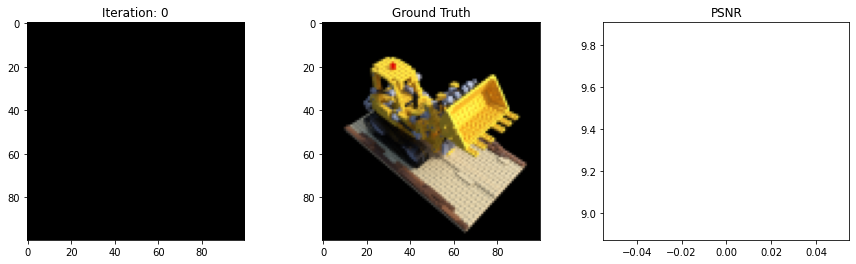

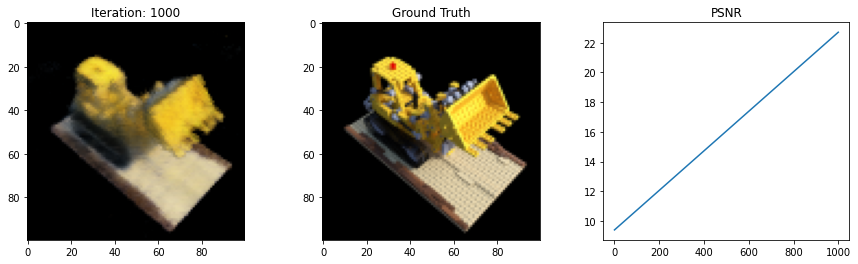

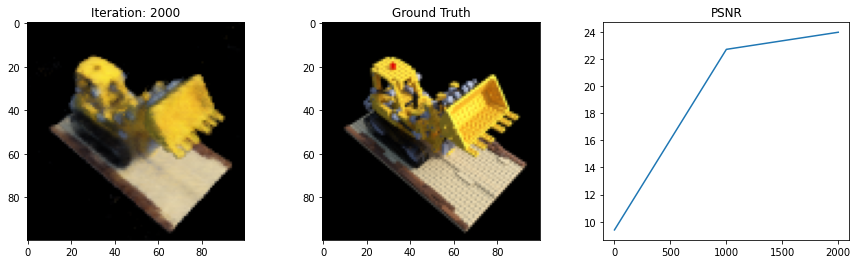

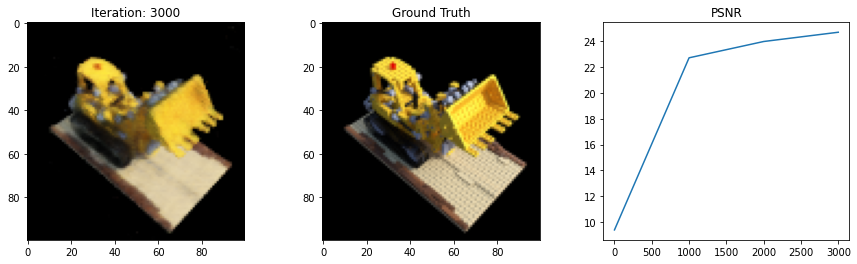

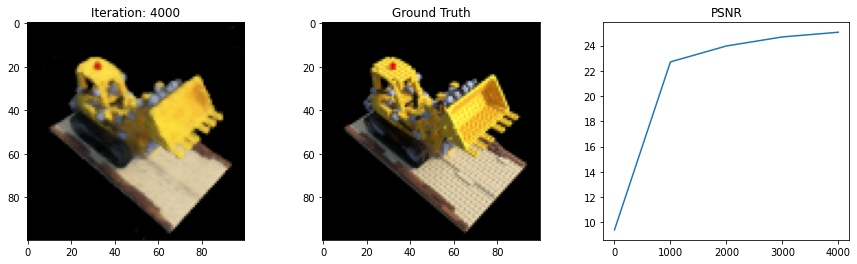

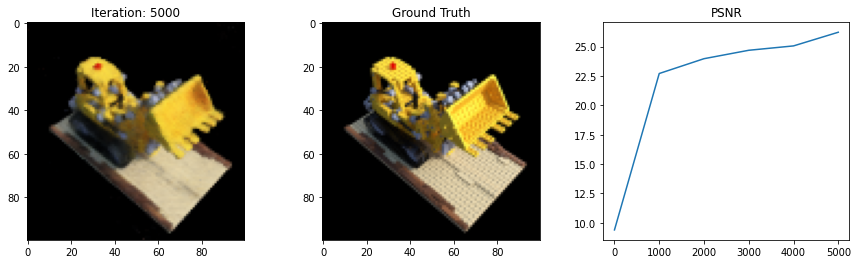

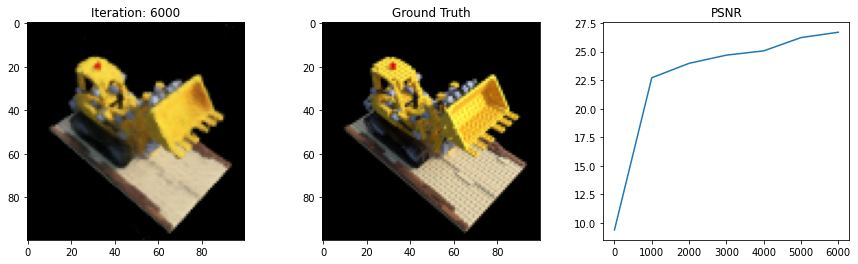

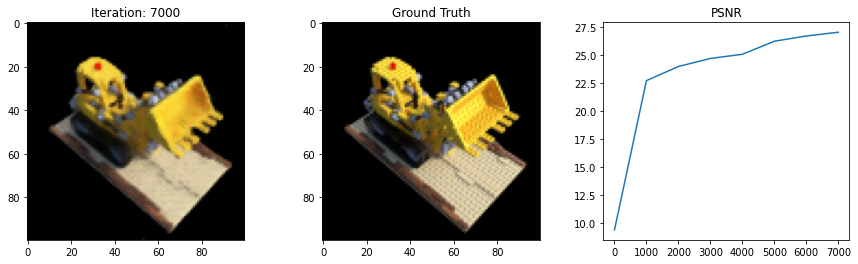

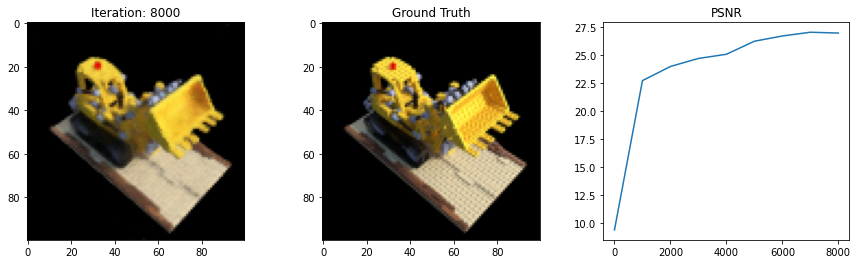

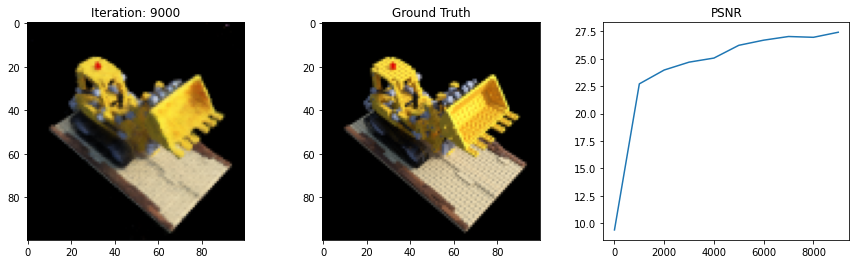

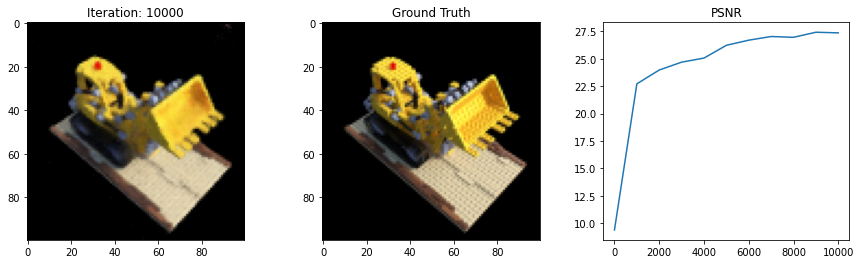

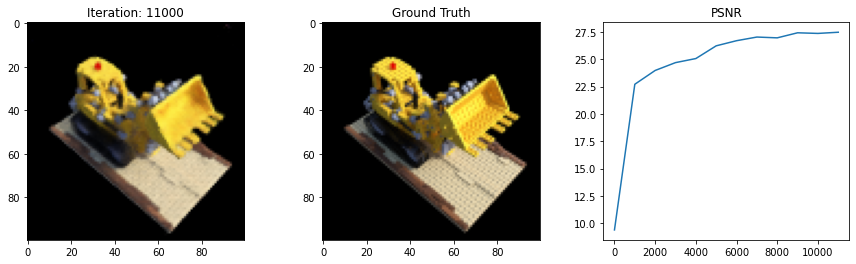

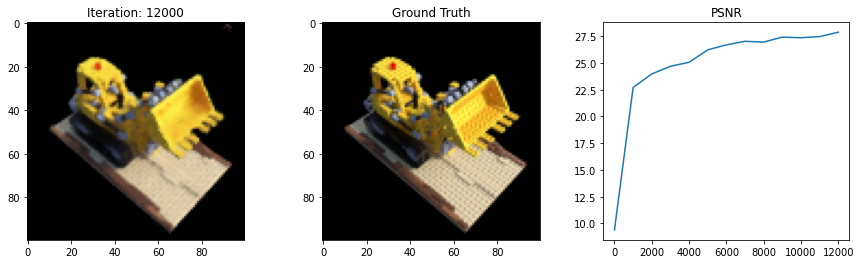

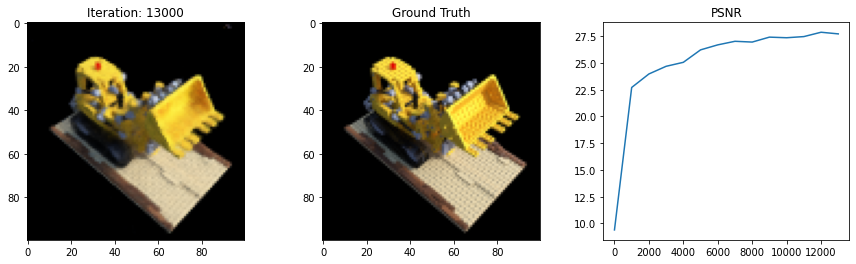

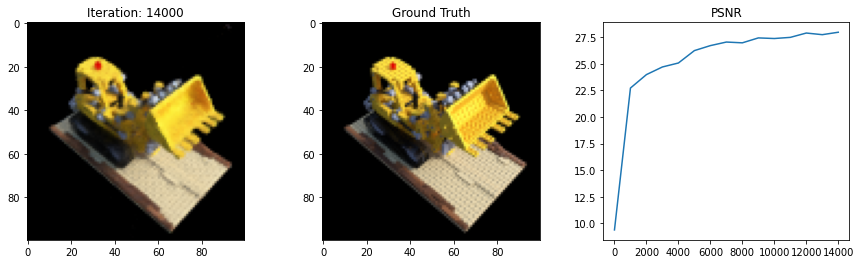

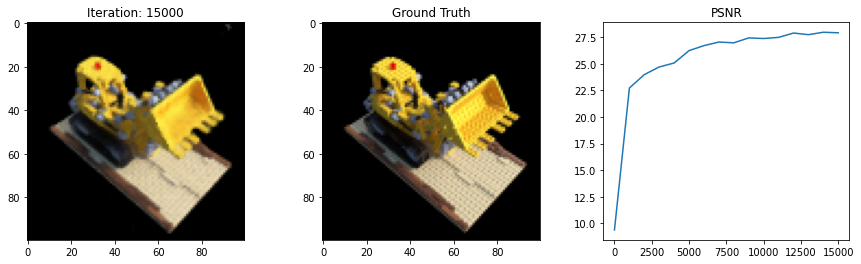

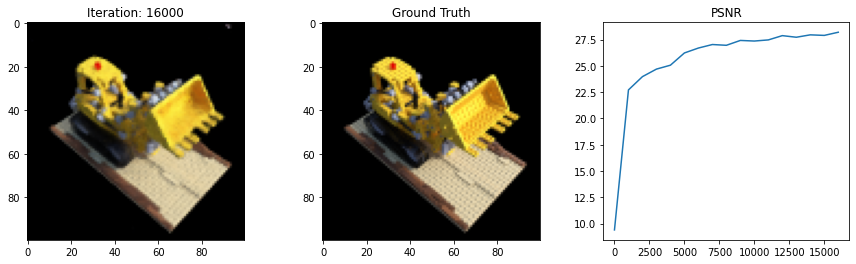

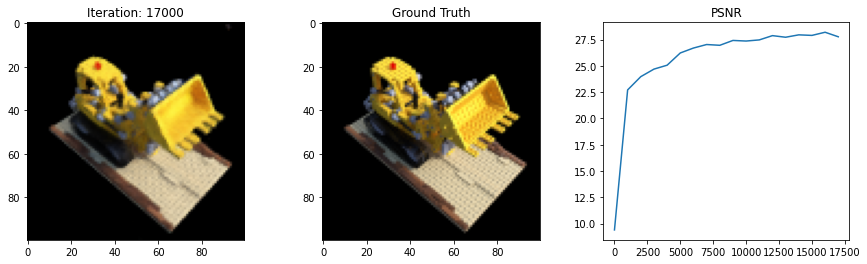

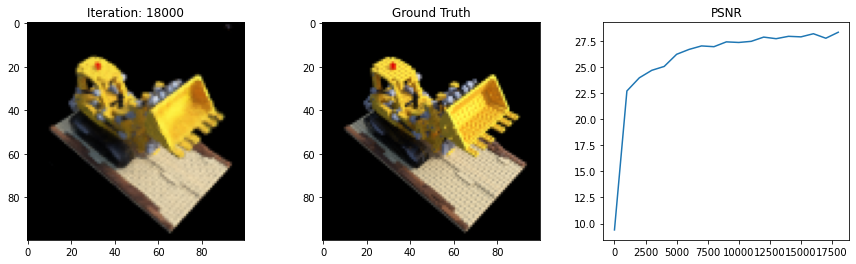

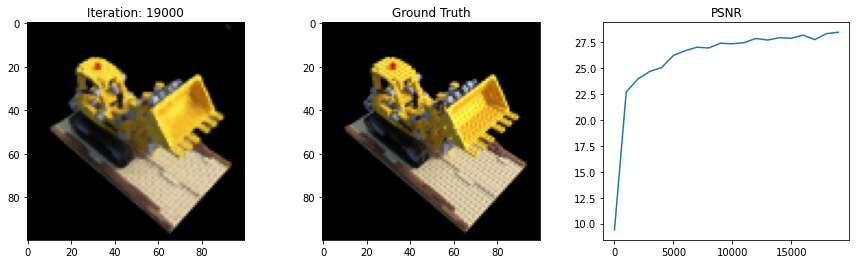

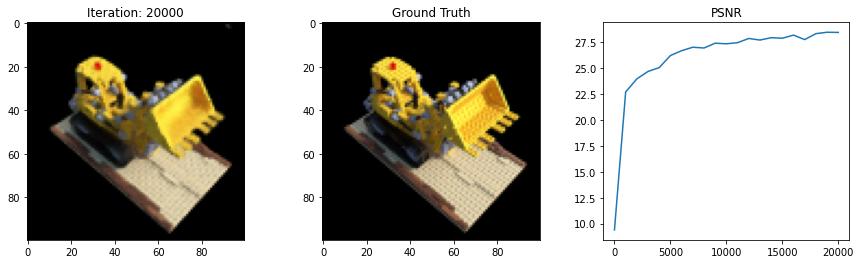

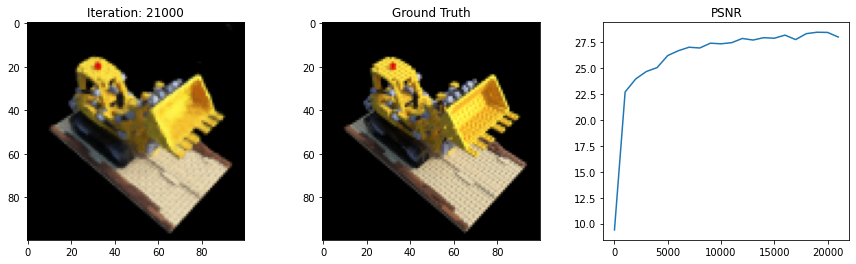

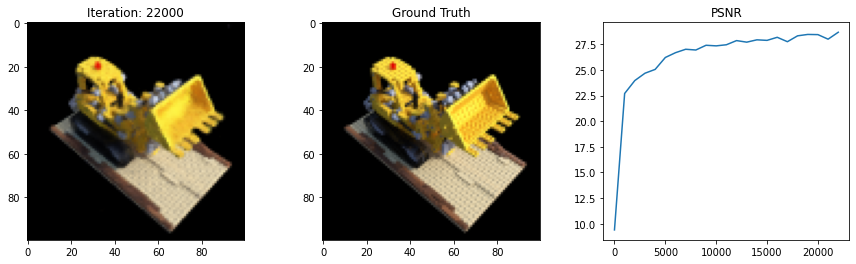

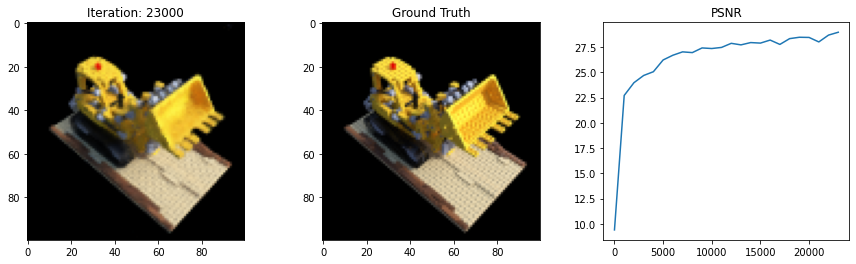

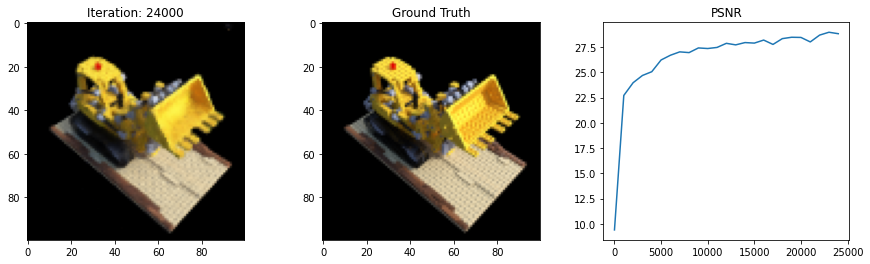

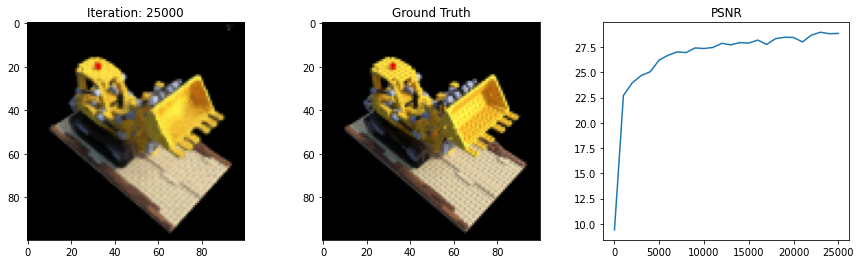

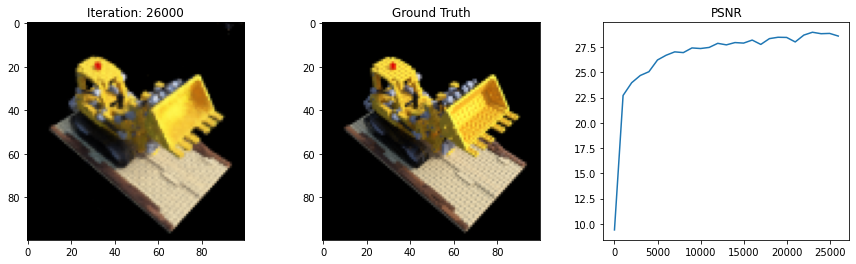

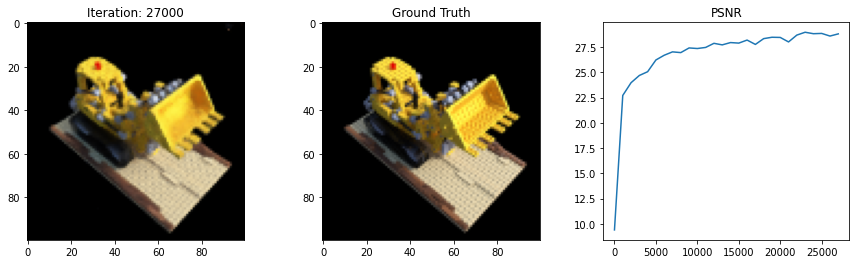

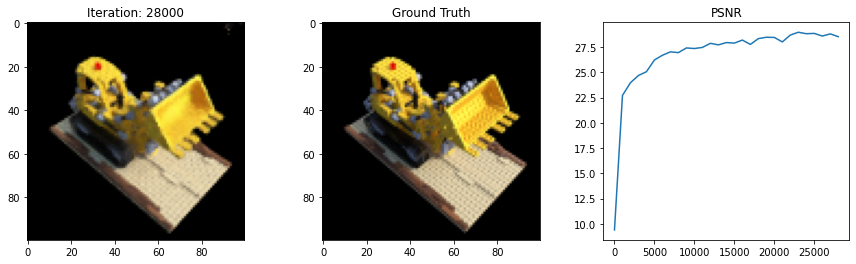

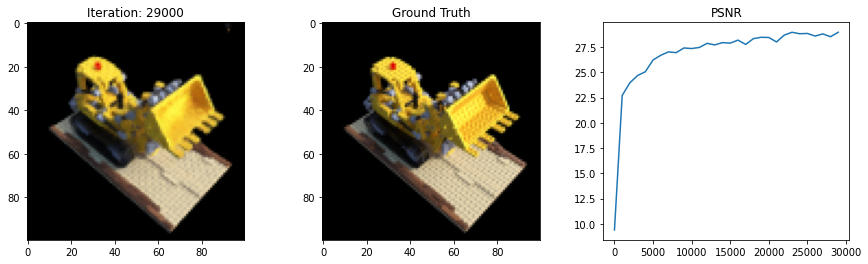

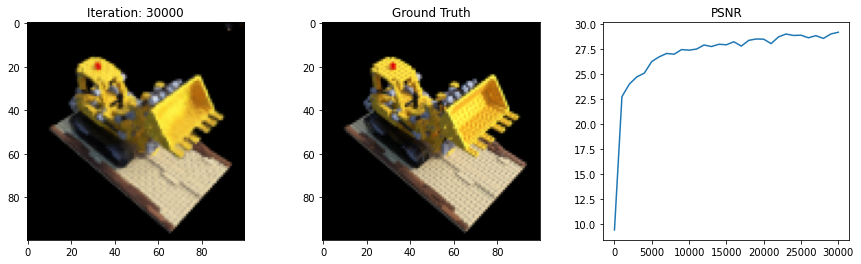

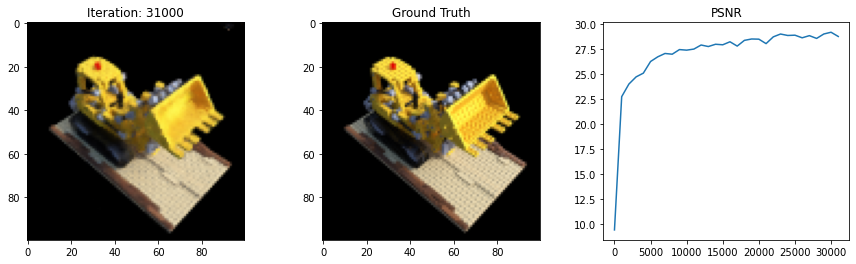

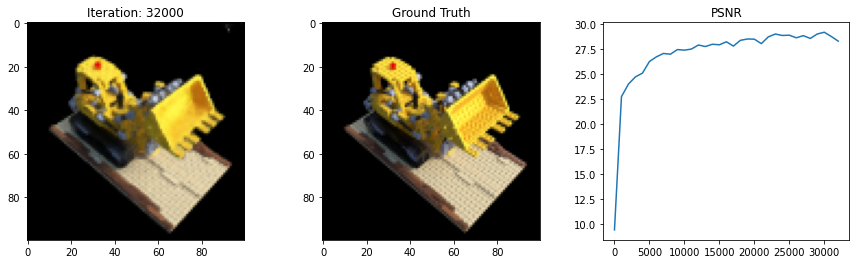

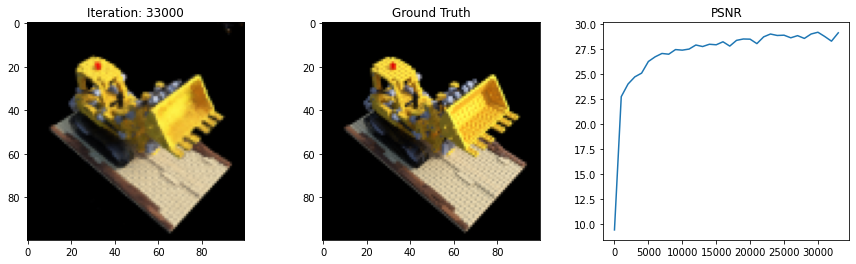

In [ ]:
psnrs = []
iternums = []

iteration = -1
for epoch in range(300):
    for target, rays_o, rays_d in data_loader:
        iteration += 1
        
        pixels = nerf.render_rays(
            rays_o,
            rays_d,  
            2.0, 
            6.0, 
            64, 
            random=True, 
            density_noise_std=1.0, 
            pose_limit=6.0)

        optimizer.zero_grad()

        loss = ((pixels - target) ** 2).mean()
        loss.backward()

        optimizer.step()
        
        if iteration % 1000 == 0:
            
            with torch.no_grad():
                
                test_render = nerf.render_image(
                    test_pose.cuda(), 
                    H, 
                    W, 
                    focal, 
                    2.0, 
                    6.0, 
                    64, 
                    pose_limit=6.0)
        
                loss = ((test_render - test_image) ** 2).mean().cpu().detach().numpy()
                psnr = -10.0 * np.log(loss) / np.log(10.0)
            
                psnrs.append(psnr)
                iternums.append(iteration)
        
            plt.figure(figsize=(15,4))
            
            plt.subplot(131)
            plt.title(f'Iteration: {iteration}')
            plt.imshow(test_render.detach().cpu().numpy()[0])
            
            plt.subplot(132)
            plt.title('Ground Truth')
            plt.imshow(test_image.detach().cpu().numpy()[0])
            
            plt.subplot(133)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            
            plt.show()

In [ ]:
torch.save(nerf.state_dict(), "nerf.pth")

In [ ]:
nerf.load_state_dict(torch.load("nerf.pth"))

In [ ]:
scale = 1

with torch.no_grad():
    test_render = nerf.render_image(
        test_pose.cuda(), 
        H * scale, 
        W * scale, 
        focal * scale, 
        2.0, 
        6.0, 
        64, 
        pose_limit=6.0)

plt.figure(figsize=(10, 4))

plt.subplot(131)
plt.title(f'Rendered')
plt.imshow(test_render.detach().cpu().numpy()[0])

plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(test_image.detach().cpu().numpy()[0])

plt.show()

In [ ]:
import matplotlib

matplotlib.image.imsave(
    'render.png', test_render.detach().cpu().numpy()[0])